# Random walk baseline

In [1]:
import numpy as np
import pandas as pd
from scipy.fftpack import dct, idct

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from music21 import converter
matplotlib.style.use('styles.mplstyle')
import scipy

import sys
sys.path.append('../')
from helpers import cm2inch, title

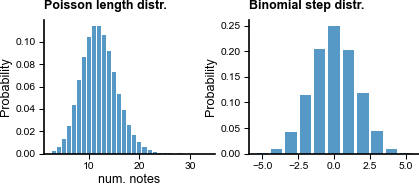

In [2]:
def show_length_distribution(lam=12, size=100000):
    lengths = np.random.poisson(lam=lam, size=size)
    lengths[np.where(lengths < 3)] = 3
    sns.histplot(lengths, stat='probability', discrete=True, lw=0, shrink=.8)
    # plt.plot(scipy.stats.poisson.pmf(range(30), mu=12), 'C3.-', lw=.5, label='Poisson(12)')
    plt.xlabel('num. notes')
    
def show_step_distribution(n=10, p=0.5, size=100000):
    steps = np.random.binomial(n=n, p=p, size=size) - n*p
    sns.histplot(steps, stat='probability', discrete=True, lw=0, shrink=.8)
    title('Binomial step distr.')
    

plt.figure(figsize=cm2inch(8.2, 3))
plt.subplot(121)
show_length_distribution()
title('Poisson length distr.')

plt.subplot(122)
show_step_distribution()
title('Binomial step distr.')

In [3]:
def random_contour(lam=12, num_samples=50, n=10, p=0.5):
    length = max(3, np.random.poisson(lam=lam))
    contour = [np.random.randint(60,85)]
    for i in range(1, length):
        step = np.random.binomial(n, p) - n*p
        step = min(max(-12, step), 12)
        if (contour[i-1] + step > 84) or (contour[i-1] + step < 60):
            contour.append(contour[i-1] - step)
        else:
            contour.append(contour[i-1] + step)
            
    contour.append(contour[-1])
    times = np.linspace(0, 1, len(contour))
    func = scipy.interpolate.interp1d(times, contour, kind='previous')
    return func(np.linspace(0, 1, num_samples))

In [4]:
contours = np.array([random_contour() for _ in range(10000)])

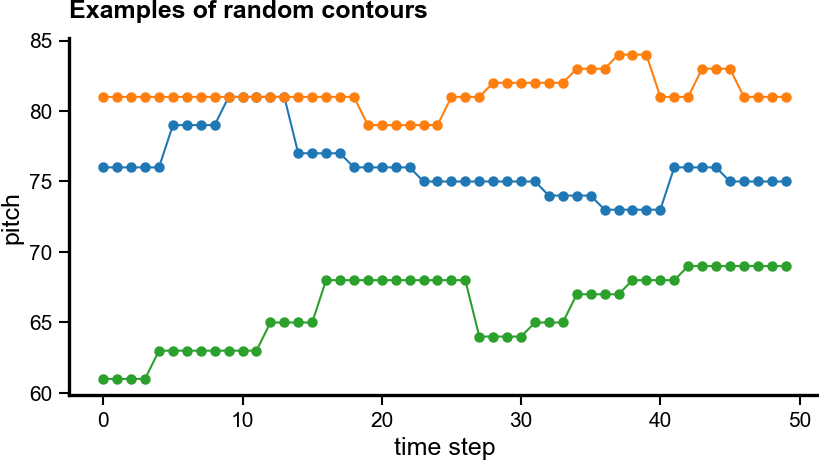

In [5]:
def show_random_contour_examples(contours=contours, num_examples=3):
    plt.plot(contours[:num_examples, :].T, '.-', lw=.5)
    plt.xlabel('time step')
    plt.ylabel('pitch')
    
plt.figure(figsize=cm2inch(8.2, 4))
show_random_contour_examples()
title('Examples of random contours')

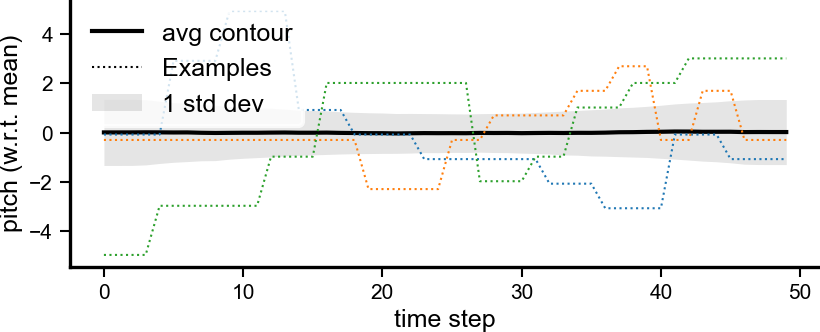

In [6]:
def show_avg_contour(contours, f=1, num_examples=3, color='k'):
    xs = np.arange(contours.shape[1])
    contours = contours - contours.mean(axis=1)[:, np.newaxis]
    mean = contours.mean(axis=0)
    std = f/2 * contours.std(axis=0)
    plt.plot(xs, mean, color, lw=1, label=f'avg contour')
    plt.fill_between(xs, mean-std, mean+std, alpha=.1, 
                     color=color, label=f'1 std dev', lw=0)    
    plt.plot(xs, contours[:num_examples, :].T, ':', lw=.5) 
    plt.plot(0, 0, 'k:', lw=.5, label='Examples')
    plt.legend()
    plt.ylabel('pitch (w.r.t. mean)')
    plt.xlabel('time step')
    
plt.figure(figsize=cm2inch(8.2, 3))
show_avg_contour(contours)

## Combined plot

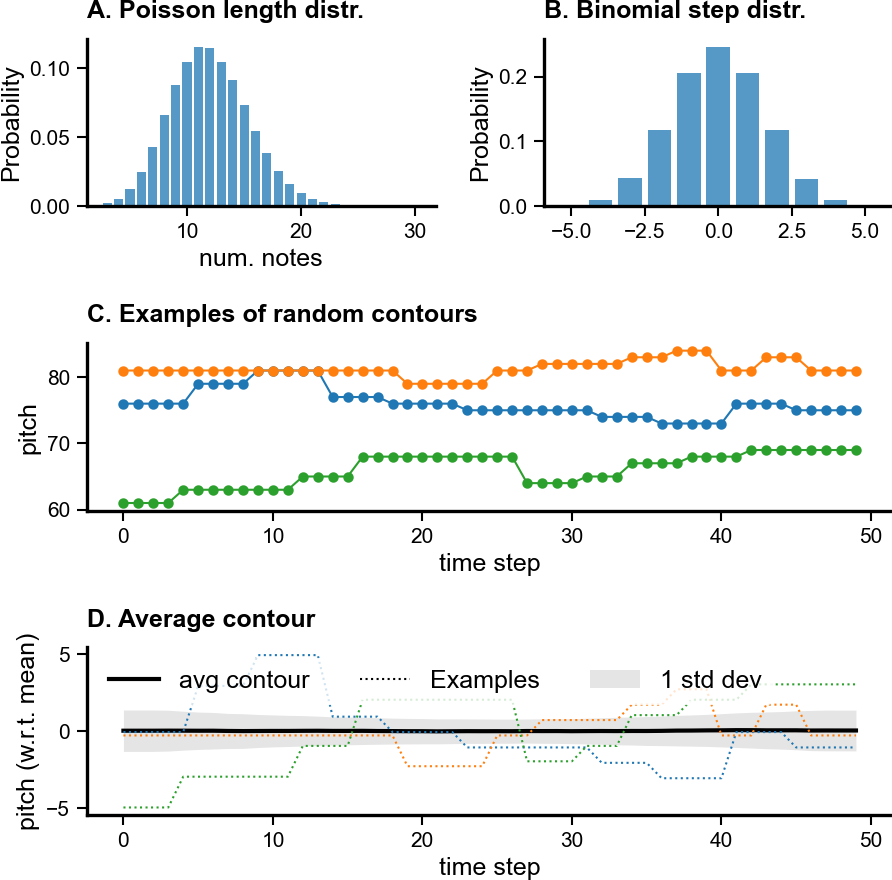

In [7]:
fig = plt.figure(figsize=cm2inch(8.2, 8))
gs = gridspec.GridSpec(3, 2)

ax = fig.add_subplot(gs[0, 0])
show_length_distribution()
title('A. Poisson length distr.')

ax = fig.add_subplot(gs[0, 1])
show_step_distribution()
title('B. Binomial step distr.')

ax = fig.add_subplot(gs[1, :])
show_random_contour_examples()
title('C. Examples of random contours')

ax = fig.add_subplot(gs[2, :])
show_avg_contour(contours)
title('D. Average contour')
plt.legend(ncol=3)

plt.tight_layout()
plt.savefig('../figures/suppl-S1/figS01a.pdf')

## Toeplitz difference

In [8]:
def toeplitz_difference(S):
    diffs = np.zeros(S.shape)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            k = j - i
            avg = np.mean(np.diag(S, k))
            diffs[i, j] = S[i, j] - avg
    return diffs

In [9]:
contours4 = np.array([random_contour(lam=4, num_samples=100) for _ in range(10000)])
contours12 = np.array([random_contour(lam=12, num_samples=100) for _ in range(10000)])
contours50 = np.array([random_contour(lam=50, num_samples=100) for _ in range(10000)])
contours100 = np.array([random_contour(lam=100, num_samples=100) for _ in range(10000)])

In [10]:
S4 = np.cov(contours4.T)
S12 = np.cov(contours12.T)
S50 = np.cov(contours50.T)
S100 = np.cov(contours100.T)

In [11]:
def title(text, ax=None):
    if ax is None: ax = plt.gca()
    ax.set_title(text, ha='left', x=0)

/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bas/repos/papers/ISMIR2021/env/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


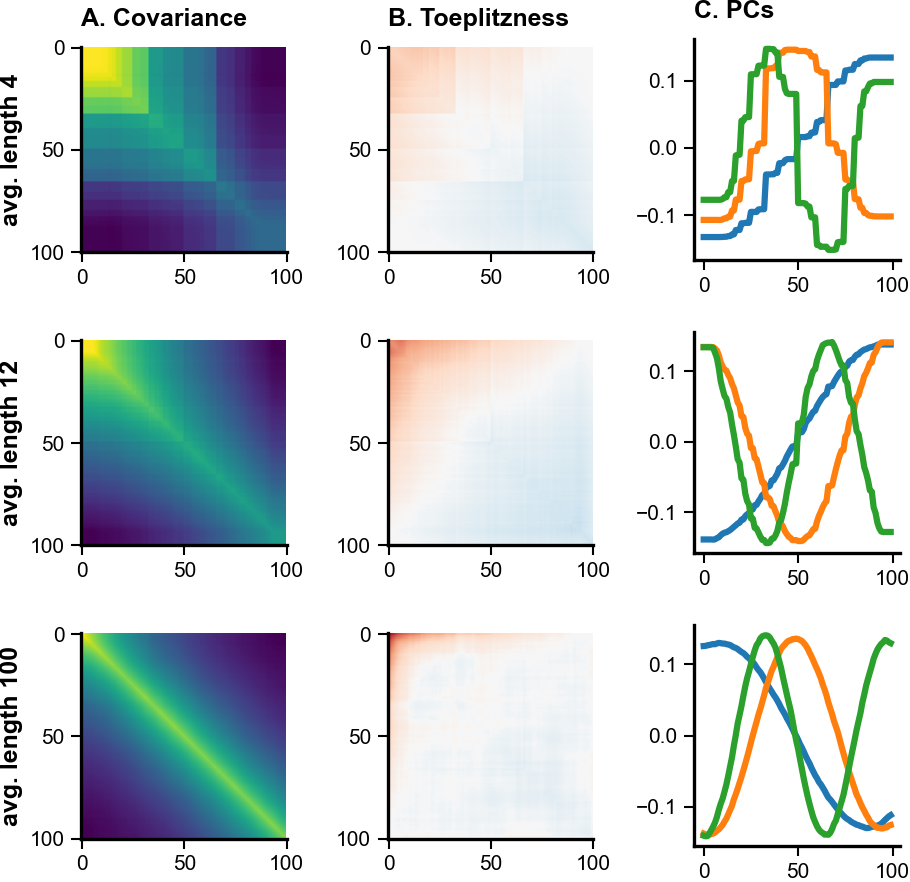

In [12]:
def show_row(S, gs, row, cbar=False):
    ax1 = fig.add_subplot(gs[row, 0])
    plt.imshow(S)
    plt.xticks([0, 50, 100])
    plt.yticks([0, 50, 100])
    if cbar: plt.colorbar()
    
    ax2 = fig.add_subplot(gs[row, 1])
    plt.imshow(toeplitz_difference(S),
           cmap='RdBu_r', vmin=-10, vmax=10)
    plt.xticks([0, 50, 100])
    plt.yticks([0, 50, 100])
    if cbar: plt.colorbar()
        
    ax3 = fig.add_subplot(gs[row, 2])
    lam, V = np.linalg.eig(S)
    top_lambdas = lam.argsort()[::-1][1:4]
    plt.plot(V[:, top_lambdas])
    
    return ax1, ax2, ax3

fig = plt.figure(figsize=cm2inch(8.2, 8))
gs = gridspec.GridSpec(3, 3)

ax1, ax2, ax3 = show_row(S4, gs, 0, cbar=False)
title('A. Covariance', ax=ax1)
title('B. Toeplitzness', ax=ax2)
title('C. PCs', ax=ax3)
ax1.set_ylabel('avg. length 4', fontweight='bold')

axs = show_row(S12, gs, 1, cbar=False)
axs[0].set_ylabel('avg. length 12', fontweight='bold')

axs = show_row(S100, gs, 2, cbar=False)
axs[0].set_ylabel('avg. length 100', fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/suppl-S1/figS01b.pdf')